The aim of this exercise is to predict whether a patient has diabetes using data from the National Institute of Diabetes and Digestive and Kidney Diseases using a boosting model

**Note:** the full exploratory data analysis can be found here: https://github.com/linama2593/Decis_Tree_Diabetes 

# Imports:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pickle import dump, load
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn import tree


# Opening train and test data

In [3]:

X_train_nn=pd.read_csv('https://raw.githubusercontent.com/linama2593/Decis_Tree_Diabetes/main/data/processed/X_train_nn.csv')
X_test_nn=pd.read_csv('https://raw.githubusercontent.com/linama2593/Decis_Tree_Diabetes/main/data/processed/X_test_nn.csv')

y_train=pd.read_csv("https://raw.githubusercontent.com/linama2593/Decis_Tree_Diabetes/main/data/processed/y_train.txt", header=None)
y_test=pd.read_csv("https://raw.githubusercontent.com/linama2593/Decis_Tree_Diabetes/main/data/processed/y_test.txt", header=None)
#the code above imports y as dataframe, below I convert it to a pd series
y_train=y_train[0]
y_test=y_test[0]

# Boosting algorithm - Baseline estimation

In [4]:

boost_base= XGBClassifier(random_state = 42)
boost_base.fit(X_train_nn, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [5]:
y_pred_train=boost_base.predict(X_train_nn)
y_pred=boost_base.predict(X_test_nn)

## Model performance

Accuracy train vs test data:

The baseline model suggests there is overfitting since the accuracy of the training data is higher than the test data. Neverthless, the baseline accuracy of the random forest is 74%, which is 4 percentage points lower than the one obtained from the optimised random forest

In [6]:
boost_acc_base=accuracy_score(y_pred,y_test)
boost_acc_train=accuracy_score(y_pred_train,y_train)
print('Random forest - Accuracy train: ', boost_acc_train)
print('Random forest - Accuracy test: ', boost_acc_base)

Random forest - Accuracy train:  1.0
Random forest - Accuracy test:  0.7402597402597403


Storung confusion matrix to plot it after optimisation

In [8]:
boost_base_cm = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred), display_labels = ['NO Diabetes', 'Diabetes']    )

# Hyperparameter tunning

## Random search CV

The random search will provide an overall idea of where the best hyperparameters are. Using np.random.randint() for some of othe hyperparameters will reduce the estimation time as the function will pick different integers on each iteration as opposed to working with a full range. Also, skipping the random state will allow to try different combinations each time the model is re-run 

In [9]:
from random import randint
hyprms={
    'booster': ['gbtree', 'gblinear', 'dart'],
    'n_estimators': np.random.randint(50,700,5),
    #params for bgtree
    'min_child_weight': np.linspace(0.01, 1, 5, endpoint=False),
    'colsample_bylevel': np.linspace(0.01, 1, 5,),
    'learning_rate': np.linspace(0.01, 1, 5),
    'min_split_loss': np.random.randint(100, 600,5),
    'subsample': np.linspace(0.01, 1, 5, endpoint=False),
    'max_depth': np.random.randint(0,500,5)
#'colsample_by_level'
}
score=['accuracy', 'f1']

kfold=StratifiedKFold(n_splits=5)

In [12]:
boost_opt=RandomizedSearchCV(boost_base, hyprms, scoring='accuracy', cv=kfold, refit=True, n_iter = 50)#, random_state = 42)

In [13]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

boost_opt.fit(X_train_nn,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                                        'colsample_bylevel': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                                        'learning_rate': array([0.01  , 0.2575, 0.505 , 0.7525, 1.    ]),
                                        'max_depth': array([ 27,  39, 469, 434,  18]),
                                        'min_child_weight': array([0.01 , 0.208, 0.406, 0.604, 0.802]),
                                        'min_split_loss': array([570, 447, 249, 124, 546]),
                                        'n_estimators': array([140, 617, 211,  88, 452]),
                                        'subsample': array([0.01 , 0.208, 0.406, 0.604, 0.802])},
                   scoring='accuracy')

Since the random search does not have a random state, here I store the findings to re-estimate the model with the combinations of hyperparamenters that performed best

In [14]:
#Storing Grid search results as dataframe
result=pd.DataFrame(boost_opt.cv_results_)

to_rename = {'param_n_estimators': "n_estimators", 
    'param_min_samples_split': 'min_samples_split',
       'param_min_samples_leaf': 'min_samples_leaf', 
       'param_max_depth': 'max_depth'}

result.rename(columns=to_rename, inplace=True)# Rename the columns

In [20]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_fit_time            50 non-null     float64
 1   std_fit_time             50 non-null     float64
 2   mean_score_time          50 non-null     float64
 3   std_score_time           50 non-null     float64
 4   param_subsample          50 non-null     object 
 5   n_estimators             50 non-null     object 
 6   param_min_split_loss     50 non-null     object 
 7   param_min_child_weight   50 non-null     object 
 8   max_depth                50 non-null     object 
 9   param_learning_rate      50 non-null     object 
 10  param_colsample_bylevel  50 non-null     object 
 11  param_booster            50 non-null     object 
 12  params                   50 non-null     object 
 13  split0_test_score        50 non-null     float64
 14  split1_test_score        50 

**Graph accuracy vs hyperparameters:**

*   Number of trees: the relationship is non-linear, it is not clear from the graph whether more trees in the model are associated with higher accuracy, at least for this training data. 

*   Min N required to split: a higher percentange of the minimum sample required for the model to make the split is associated with lower accuracy. In other words, a higher sample size required to split a node is associated with lower accuracy

*   Min N within leaf: a higher percentange of the minimum sample required within a leaf is associated with lower accuracy. In other words, a higher sample size required within a leaf is associated with lower accuracy. The peak decline in accuracy approximately occurs after 0.3

*   Maximum depth: it seems like the maximum depth follows an inverse parabolic relationsip with accuracy, meaning that, in very low or very high values of maximum depth, accuracy seems to be lower. In contrast, within middle values of maximum depth, accuracy is higher

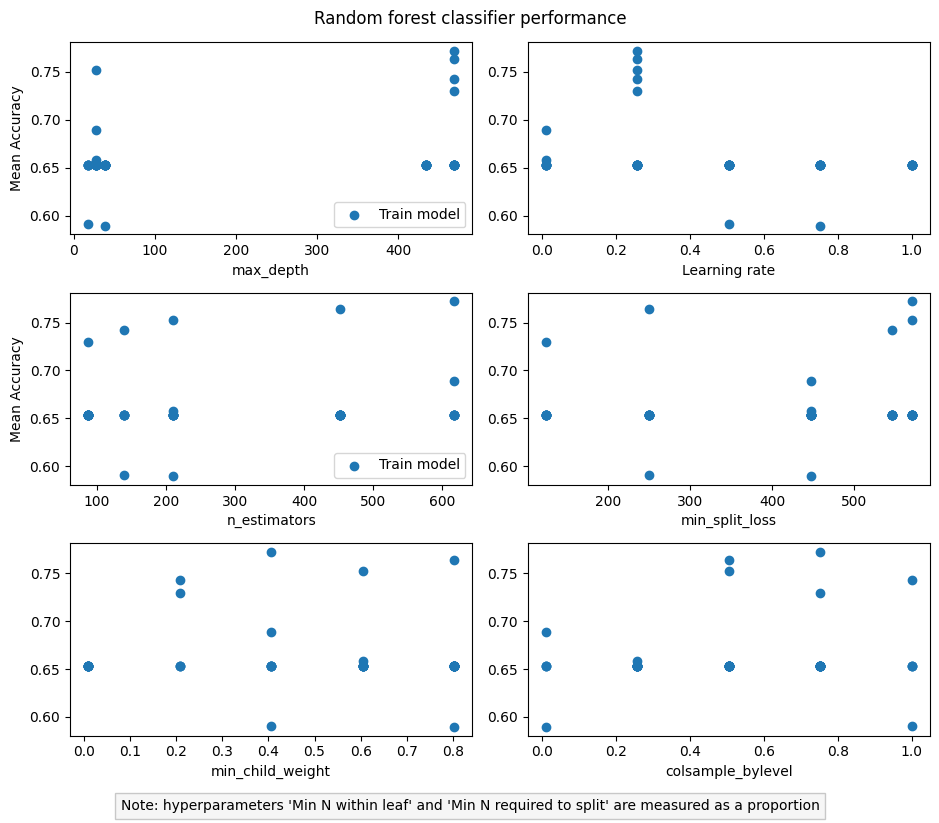

In [15]:
metrics2=result


fig, ax = plt.subplots(3,2, figsize=(9.5,8))

ax[0,0].scatter(metrics2['max_depth'], metrics2['mean_test_score'], label='Train model')
ax[0,0].set_ylabel('Mean Accuracy')
ax[0,0].set_xlabel('max_depth')
#ax[0,0].set_title('All alpha values')
ax[0,0].legend()


ax[0,1].scatter(metrics2['param_learning_rate'], metrics2['mean_test_score'])
ax[0,1].set_xlabel('Learning rate')
#ax[0,1].set_title('Only alpha values>0')

ax[1,0].scatter(metrics2['n_estimators'], metrics2['mean_test_score'], label='Train model')
ax[1,0].set_ylabel('Mean Accuracy')
ax[1,0].set_xlabel('n_estimators')
ax[1,0].legend()

ax[1,1].scatter(metrics2['param_min_split_loss'], metrics2['mean_test_score'])
ax[1,1].set_xlabel('min_split_loss')

ax[2,0].scatter(metrics2['param_min_child_weight'], metrics2['mean_test_score'])
ax[2,0].set_xlabel('min_child_weight')

ax[2,1].scatter(metrics2['param_colsample_bylevel'], metrics2['mean_test_score'])
ax[2,1].set_xlabel('colsample_bylevel')

note_text = "Note: hyperparameters 'Min N within leaf' and 'Min N required to split' are measured as a proportion"
fig.text(0.5, -0.02, note_text, ha='center', fontsize=10,
         bbox=dict(facecolor='lightgray', alpha=0.2))

plt.suptitle('Random forest classifier performance')
plt.tight_layout()
plt.show()

Selecting the best performing 10 models:

In [43]:
best_models=result.nlargest(10, 'mean_test_score')

In [44]:
best_models

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,n_estimators,param_min_split_loss,param_min_child_weight,max_depth,param_learning_rate,...,param_booster,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
38,0.049019,0.002661,0.002764,0.000047,0.01,617,570,0.406,469,0.2575,...,gblinear,"{'subsample': 0.01, 'n_estimators': 617, 'min_...",0.756098,0.821138,0.739837,0.756098,0.786885,0.772011,0.028901,1
5,0.035823,0.001547,0.002513,0.000114,0.406,452,249,0.802,469,0.2575,...,gblinear,"{'subsample': 0.406, 'n_estimators': 452, 'min...",0.756098,0.813008,0.723577,0.756098,0.770492,0.763854,0.028992,2
36,0.022883,0.008282,0.002583,0.000107,0.208,211,570,0.604,27,0.2575,...,gblinear,"{'subsample': 0.20800000000000002, 'n_estimato...",0.747967,0.788618,0.739837,0.739837,0.745902,0.752432,0.018381,3
14,0.013818,0.001404,0.002418,0.000066,0.01,140,546,0.208,469,0.2575,...,gblinear,"{'subsample': 0.01, 'n_estimators': 140, 'min_...",0.723577,0.764228,0.747967,0.731707,0.745902,0.742676,0.014057,4
11,0.009668,0.000504,0.002385,0.000029,0.406,88,124,0.208,469,0.2575,...,gblinear,"{'subsample': 0.406, 'n_estimators': 88, 'min_...",0.715447,0.747967,0.723577,0.723577,0.737705,0.729655,0.011627,5
9,0.046995,0.002427,0.003188,0.001101,0.01,617,447,0.406,27,0.01,...,gblinear,"{'subsample': 0.01, 'n_estimators': 617, 'min_...",0.715447,0.658537,0.691057,0.682927,0.696721,0.688938,0.018591,6
39,0.018456,0.001341,0.002585,0.000166,0.01,211,447,0.604,27,0.01,...,gblinear,"{'subsample': 0.01, 'n_estimators': 211, 'min_...",0.666667,0.658537,0.650407,0.650407,0.663934,0.657990,0.006722,7
0,0.041162,0.016670,0.004371,0.003287,0.604,211,570,0.01,469,0.7525,...,gbtree,"{'subsample': 0.6040000000000001, 'n_estimator...",0.658537,0.650407,0.650407,0.650407,0.655738,0.653099,0.003414,8
1,0.512745,0.110294,0.019912,0.028926,0.604,140,124,0.802,39,0.7525,...,dart,"{'subsample': 0.6040000000000001, 'n_estimator...",0.658537,0.650407,0.650407,0.650407,0.655738,0.653099,0.003414,8
2,8.356124,0.255131,0.015370,0.001292,0.406,617,546,0.802,469,0.7525,...,dart,"{'subsample': 0.406, 'n_estimators': 617, 'min...",0.658537,0.650407,0.650407,0.650407,0.655738,0.653099,0.003414,8


Obtaining best hyperparameters:

In [45]:
acc=pd.DataFrame(columns=['params','accuracy'])

for hyp in best_models['params']:
    boost_opt=XGBClassifier(**hyp, random_state = 42)
    boost_opt.fit(X_train_nn, y_train)
    y_pred_train=boost_opt.predict(X_train_nn)
    acc.loc[len(acc)]={
        'accuracy':accuracy_score(y_pred_train,y_train),
        'params': hyp}

Storing best hyperparameters

In [57]:
best_params=acc.nlargest(1, 'accuracy')['params'].iloc[0]
best_params

{'subsample': 0.01,
 'n_estimators': 617,
 'min_split_loss': 570,
 'min_child_weight': 0.406,
 'max_depth': 469,
 'learning_rate': 0.2575,
 'colsample_bylevel': 0.7525,
 'booster': 'gblinear'}

# Optimised model

In [61]:
boost_opt=XGBClassifier(**best_params, random_state = 42)

In [62]:
boost_opt.fit(X_train_nn, y_train)

XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=0.7525, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2575, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=469, max_leaves=None,
              min_child_weight=0.406, min_split_loss=570, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=617,
              n_jobs=None, num_parallel_tree=None, ...)

Saving optmised model

In [63]:
dump(boost_opt, open('/workspaces/Boosting_ML_Diabetes/boostgblinear_depth87_wgt0.6_estim145_seed42.pk', 'wb'))

## Evaluating model performance

**Accuracy train vs test data**

The model accurately diagnoses 75% of the patients. Now, there seems to be no overfitting since both measures of accuracy in train and test data are now much closer.

In [64]:
y_pred_train=boost_opt.predict(X_train_nn)
y_pred=boost_opt.predict(X_test_nn)
boost_acc_opt= accuracy_score(y_pred,y_test)
print('Accuracy train: ', accuracy_score(y_pred_train,y_train))
print('Accuracy test: ', boost_acc_opt)

Accuracy train:  0.7687296416938111
Accuracy test:  0.7532467532467533


**Accuracy baseline boosting vs optimised boosting:**
The optimised boosting (RF) outperformed in accuracy the baseline model by 1.3 percentage points.

In [65]:
print('Accuracy optimised boosting : ', boost_acc_opt)
print('Accuracy baseline boosting: ', boost_acc_base)

Accuracy optimised boosting :  0.7532467532467533
Accuracy baseline boosting:  0.7402597402597403


**Confusion matrix:**

The model improved on detecting the patients who do not have diabetes but there are still 21 patients missdiagnosed (5 more, compared to the baseline).

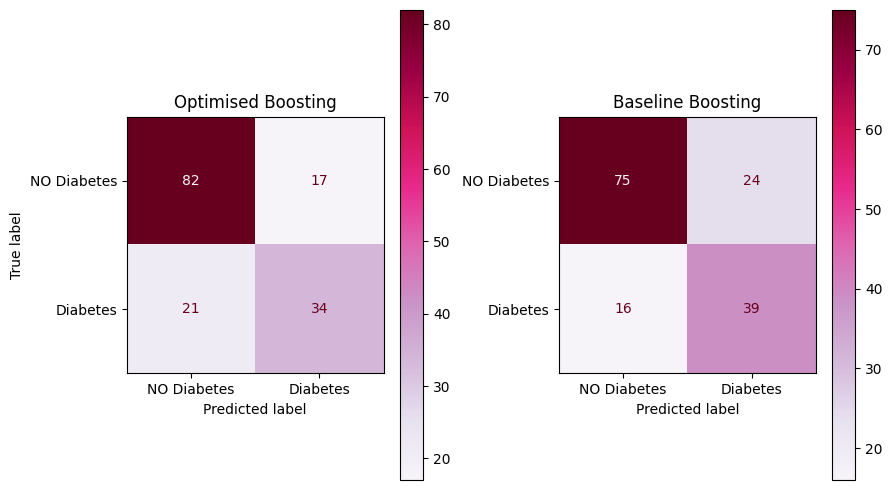

In [66]:
rf_opt_cm = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred), display_labels = ['NO Diabetes', 'Diabetes']    )
# plot CM
fig, ax= plt.subplots(1,2, figsize=(9,5))
rf_opt_cm.plot(cmap = 'PuRd', ax=ax[0])
ax[0].set_title('Optimised Boosting')

boost_base_cm.plot(cmap = 'PuRd', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_title('Baseline Boosting')

plt.tight_layout()
plt.show()